# Import Packages

In [1]:
import os
import sys
import csv
import random
import platform
import subprocess

# Set Command

In [2]:
os_name = platform.system()
if os_name == "Darwin":
    AES_command = "./AES-CLI-macOS"
    DES_command = "./DES-CLI-macOS"
    DES_ResultFile = "DES_macOS.csv"
    AES_ResultFile = "AES_macOS.csv"
elif os_name == "Linux":
    AES_command = "./AES-CLI-Linux"
    DES_command = "./DES-CLI-Linux"
    DES_ResultFile = "DES_Linux.csv"
    AES_ResultFile = "AES_Linux.csv"
elif os_name == "Windows":
    AES_command = "AES-CLI-Windows.exe"
    DES_command = "DES-CLI-Windows.exe"
    DES_ResultFile = "DES_Windows.csv"
    AES_ResultFile = "AES_Windows.csv"
else:
    print("OS not supported")
    sys.exit(1)

if not os.path.exists(AES_command) or not os.path.exists(DES_command):
    print("Please compile the C++ code first")
    sys.exit(1)

print("AES command: ", AES_command)
print("AES Result File: ", AES_ResultFile)
print("DES command: ", DES_command)
print("DES Result File: ", DES_ResultFile)

AES command:  ./AES-CLI-macOS
AES Result File:  AES_macOS.csv
DES command:  ./DES-CLI-macOS
DES Result File:  DES_macOS.csv


# Create Input Files

In [3]:
# Create directories
if not os.path.exists("./Container"):
    os.makedirs("./Container")
if not os.path.exists("./Container/Keys"):
    os.makedirs("./Container/Keys")
if not os.path.exists("./Container/Plain"):
    os.makedirs("./Container/Plain")
if not os.path.exists("./Container/Cipher"):
    os.makedirs("./Container/Cipher")
if not os.path.exists("./Container/Recovered"):
    os.makedirs("./Container/Recovered")
    
# Create a file with random data
def create_file(file_path, size_in_bytes):
    with open(file_path, 'wb') as f:
        random_bytes = bytearray(os.urandom(size_in_bytes))
        for i in range(size_in_bytes):
            random_bytes[i] = random.randint(32, 126)  # ASCII characters from space to tilde
        f.write(random_bytes)

# Create files with sizes from 1KB to 16MB
sizes = [1024, 262144, 524288, 1048576, 8388608, 16777216]

for size in sizes:
    if size < 1048576:
        FileName = f"{size // 1024}KB.txt"
        FilePath = "./Container/Plain/" + FileName
        create_file(FilePath, size)
        print(f"File {FileName} created with size {size/1024} KB")
    else:
        FileName = f"{size // 1048576}MB.txt"
        FilePath = "./Container/Plain/" + FileName
        create_file(FilePath, size)
        print(f"File {FileName} created with size {size/1048576} MB")

File 1KB.txt created with size 1.0 KB
File 256KB.txt created with size 256.0 KB
File 512KB.txt created with size 512.0 KB
File 1MB.txt created with size 1.0 MB
File 8MB.txt created with size 8.0 MB
File 16MB.txt created with size 16.0 MB


# Run DES Test

In [4]:
KeyDirectory = "./Container/Keys/"
PlainDirectory = "./Container/Plain/"
PlaintextFiles = os.listdir(PlainDirectory)
CipherDirectory = "./Container/Cipher/"
RecoveredDirectory = "./Container/Recovered/"

Modes = ["ECB", "CBC", "CFB", "OFB", "CTR"]
Formats = ["DER", "Base64", "HEX"]
defaultloops = 112

def GenarateKey(format):
    if format == "DER":
        command = f"{DES_command} keygen DER {KeyDirectory}key.bin"
    elif format == "Base64":
        command = f"{DES_command} keygen Base64 {KeyDirectory}key.pem"
    else:
        command = f"{DES_command} keygen HEX {KeyDirectory}key.hex"

    process = subprocess.Popen(command, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    output, error = process.communicate()
    
    return output.decode("utf-8"), error.decode("utf-8")

def DES_Excution(mode, format, plaintextfile, recoveredfile):
    if format == "DER":
        EncryptCommand = f"{DES_command} encrypt {mode} {KeyDirectory}key.bin DER {plaintextfile} text {CipherDirectory}cipher.bin DER"
        DecryptCommand = f"{DES_command} decrypt {mode} {KeyDirectory}key.bin DER {recoveredfile} text {CipherDirectory}cipher.bin DER"
    elif format == "Base64":
        EncryptCommand = f"{DES_command} encrypt {mode} {KeyDirectory}key.pem Base64 {plaintextfile} text {CipherDirectory}cipher.pem Base64"
        DecryptCommand = f"{DES_command} decrypt {mode} {KeyDirectory}key.pem Base64 {recoveredfile} text {CipherDirectory}cipher.pem Base64"
    else:
        EncryptCommand = f"{DES_command} encrypt {mode} {KeyDirectory}key.hex HEX {plaintextfile} text {CipherDirectory}cipher.hex HEX"
        DecryptCommand = f"{DES_command} decrypt {mode} {KeyDirectory}key.hex HEX {recoveredfile} text {CipherDirectory}cipher.hex HEX"

    process = subprocess.Popen(EncryptCommand, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    output, error = process.communicate()
    if error:
        print(error)
        sys.exit(1)
    EncryptionTime = output.decode("utf-8")
    EncryptionError = error.decode("utf-8")

    process = subprocess.Popen(DecryptCommand, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    output, error = process.communicate()
    if error:
        print(error)
        sys.exit(1)
    DecryptionTime = output.decode("utf-8")
    DecryptionError = error.decode("utf-8")

    return EncryptionTime,EncryptionError, DecryptionTime, DecryptionError

print("Start DES test...")
with open(DES_ResultFile, "w", newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["Format", "Mode", "File", "Encryption_Time", "Decryption_Time"])
    
    for format in Formats:
        # Genarate Key and IV
        output, error = GenarateKey(format)
        if error:
            print(error)
            sys.exit(1)
        print(f"[ 128 | {format} ]")

        for mode in Modes:
            for file in PlaintextFiles:
                print (f"    {mode} | {file}")
                i = 0
                while i < defaultloops:
                    # DES Encryption and Decryption
                    EncryptionTime, EncryptionError, DecryptionTime, DecryptionError = DES_Excution(mode, format, PlainDirectory + file, RecoveredDirectory + "Recovered_" + file)
                    if EncryptionError:
                        print(f"*** Encryption error for {file}: {EncryptionError}")
                        sys.exit(1)
                    if DecryptionError:
                        print(f"*** Decryption error for {file}: {DecryptionError}")
                        sys.exit(1)
                    # Write results to file
                    writer.writerow([format, mode, file, EncryptionTime, DecryptionTime])

                    i = i + 1

print("Successfully run DES test!")

Start DES test...
[ 128 | DER ]
    ECB | 1KB.txt
    ECB | 1MB.txt
    ECB | 256KB.txt
    ECB | 512KB.txt
    ECB | 16MB.txt
    ECB | 8MB.txt
    CBC | 1KB.txt
    CBC | 1MB.txt
    CBC | 256KB.txt
    CBC | 512KB.txt
    CBC | 16MB.txt
    CBC | 8MB.txt
    CFB | 1KB.txt
    CFB | 1MB.txt
    CFB | 256KB.txt
    CFB | 512KB.txt
    CFB | 16MB.txt
    CFB | 8MB.txt
    OFB | 1KB.txt
    OFB | 1MB.txt
    OFB | 256KB.txt
    OFB | 512KB.txt
    OFB | 16MB.txt
    OFB | 8MB.txt
    CTR | 1KB.txt
    CTR | 1MB.txt
    CTR | 256KB.txt
    CTR | 512KB.txt
    CTR | 16MB.txt
    CTR | 8MB.txt
[ 128 | Base64 ]
    ECB | 1KB.txt
    ECB | 1MB.txt
    ECB | 256KB.txt
    ECB | 512KB.txt
    ECB | 16MB.txt
    ECB | 8MB.txt
    CBC | 1KB.txt
    CBC | 1MB.txt
    CBC | 256KB.txt
    CBC | 512KB.txt
    CBC | 16MB.txt
    CBC | 8MB.txt
    CFB | 1KB.txt
    CFB | 1MB.txt
    CFB | 256KB.txt
    CFB | 512KB.txt
    CFB | 16MB.txt
    CFB | 8MB.txt
    OFB | 1KB.txt
    OFB | 1MB.txt
    OFB | 2

# Run AES Test

In [6]:
KeyDirectory = "./Container/Keys/"
PlainDirectory = "./Container/Plain/"
PlaintextFiles = os.listdir(PlainDirectory)
CipherDirectory = "./Container/Cipher/"
RecoveredDirectory = "./Container/Recovered/"

Modes = ["ECB", "CBC", "CFB", "OFB", "CTR", "XTS", "GCM", "CCM"]
Formats = ["DER", "Base64", "HEX"]
KeySizes = [128, 192, 256]
defaultloops = 26

def GenarateKey(keysize, format, keyfile):
    if format == "DER":
        command = f"{AES_command} keygen {keysize} DER {keyfile}.bin"
    elif format == "Base64":
        command = f"{AES_command} keygen {keysize} Base64 {keyfile}.pem"
    else:
        command = f"{AES_command} keygen {keysize} HEX {keyfile}.hex"

    process = subprocess.Popen(command, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    output, error = process.communicate()
    
    return output.decode("utf-8"), error.decode("utf-8")

def AES_Excution(keysize, mode, format, plaintextfile, recoveredfile):
    if format == "DER":
        EncryptCommand = f"{AES_command} encrypt {mode} {KeyDirectory}key{keysize}.bin DER {plaintextfile} text {CipherDirectory}cipher.bin DER"
        DecryptCommand = f"{AES_command} decrypt {mode} {KeyDirectory}key{keysize}.bin DER {recoveredfile} text {CipherDirectory}cipher.bin DER"
    elif format == "Base64":
        EncryptCommand = f"{AES_command} encrypt {mode} {KeyDirectory}key{keysize}.pem Base64 {plaintextfile} text {CipherDirectory}cipher.pem Base64"
        DecryptCommand = f"{AES_command} decrypt {mode} {KeyDirectory}key{keysize}.pem Base64 {recoveredfile} text {CipherDirectory}cipher.pem Base64"
    else:
        EncryptCommand = f"{AES_command} encrypt {mode} {KeyDirectory}key{keysize}.hex HEX {plaintextfile} text {CipherDirectory}cipher.hex HEX"
        DecryptCommand = f"{AES_command} decrypt {mode} {KeyDirectory}key{keysize}.hex HEX {recoveredfile} text {CipherDirectory}cipher.hex HEX"
    
    process = subprocess.Popen(EncryptCommand, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    output, error = process.communicate()
    EncryptionTime = output.decode("utf-8")
    EncryptionError = error.decode("utf-8")

    process = subprocess.Popen(DecryptCommand, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    output, error = process.communicate()
    DecryptionTime = output.decode("utf-8")
    DecryptionError = error.decode("utf-8")

    return EncryptionTime, EncryptionError, DecryptionTime, DecryptionError

print("Start AES test...")
with open(AES_ResultFile, "w", newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["KeySize", "Format", "Mode", "File", "Encryption_Time", "Decryption_Time"])
    
    for keysize in KeySizes:
        for format in Formats:
            # Genarate Key and IV
            keyfile = KeyDirectory + "key" + str(keysize)
            output, error = GenarateKey(keysize, format, keyfile)
            if error:
                print(error)
                sys.exit(1)
            print(f"[ {keysize} | {format} ]")

            for mode in Modes:
                if keysize in [128, 192] and mode == "XTS":
                    continue # 128-bits and 192-bits is not suitable for XTS Mode

                for file in PlaintextFiles:
                    print (f"    {mode} | {file}")
                    i = 0
                    while i < defaultloops:
                        # AES Encryption and Decryption
                        EncryptionTime, EncryptionError, DecryptionTime, DecryptionError = AES_Excution(keysize, mode, format, PlainDirectory + file, RecoveredDirectory + "Recovered_" + file)
                        if EncryptionError:
                            print(f"*** Encryption error for {file}: {EncryptionError}")
                            sys.exit(1)
                        if DecryptionError:
                            print(f"*** Decryption error for {file}: {DecryptionError}")
                            sys.exit(1)
                        # Write results to file
                        writer.writerow([keysize, format, mode, file, EncryptionTime, DecryptionTime])

                        i = i + 1
                    
print("Successfully run AES test!")

Start AES test...
[ 128 | DER ]
    ECB | 1KB.txt
    ECB | 1MB.txt
    ECB | 256KB.txt
    ECB | 512KB.txt
    ECB | 16MB.txt
    ECB | 8MB.txt
    CBC | 1KB.txt
    CBC | 1MB.txt
    CBC | 256KB.txt
    CBC | 512KB.txt
    CBC | 16MB.txt
    CBC | 8MB.txt
    CFB | 1KB.txt
    CFB | 1MB.txt
    CFB | 256KB.txt
    CFB | 512KB.txt
    CFB | 16MB.txt
    CFB | 8MB.txt
    OFB | 1KB.txt
    OFB | 1MB.txt
    OFB | 256KB.txt
    OFB | 512KB.txt
    OFB | 16MB.txt
    OFB | 8MB.txt
    CTR | 1KB.txt
    CTR | 1MB.txt
    CTR | 256KB.txt
    CTR | 512KB.txt
    CTR | 16MB.txt
    CTR | 8MB.txt
    GCM | 1KB.txt
    GCM | 1MB.txt
    GCM | 256KB.txt
    GCM | 512KB.txt
    GCM | 16MB.txt
    GCM | 8MB.txt
    CCM | 1KB.txt
    CCM | 1MB.txt
    CCM | 256KB.txt
    CCM | 512KB.txt
    CCM | 16MB.txt
    CCM | 8MB.txt
[ 128 | Base64 ]
    ECB | 1KB.txt
    ECB | 1MB.txt
    ECB | 256KB.txt
    ECB | 512KB.txt
    ECB | 16MB.txt
    ECB | 8MB.txt
    CBC | 1KB.txt
    CBC | 1MB.txt
    CBC | 2

# Comparison based on Input Sizes

DES Results on Linux:
Algorithm Mode      File  encryption_mean  decryption_mean
      DES  ECB   1KB.txt            2.841            2.465
      DES  ECB 256KB.txt           16.358           13.205
      DES  ECB 512KB.txt           29.534           24.002
      DES  ECB   1MB.txt           56.571           45.275
      DES  ECB   8MB.txt          414.142          331.320
      DES  ECB  16MB.txt          824.044          652.671
      DES  CBC   1KB.txt            2.640            2.276
      DES  CBC 256KB.txt           15.351           11.961
      DES  CBC 512KB.txt           31.559           23.731
      DES  CBC   1MB.txt           55.844           42.374
      DES  CBC   8MB.txt          421.462          323.494
      DES  CBC  16MB.txt          844.333          642.364
      DES  CFB   1KB.txt            2.724            2.376
      DES  CFB 256KB.txt           16.030           12.694
      DES  CFB 512KB.txt           29.561           22.826
      DES  CFB   1MB.txt          

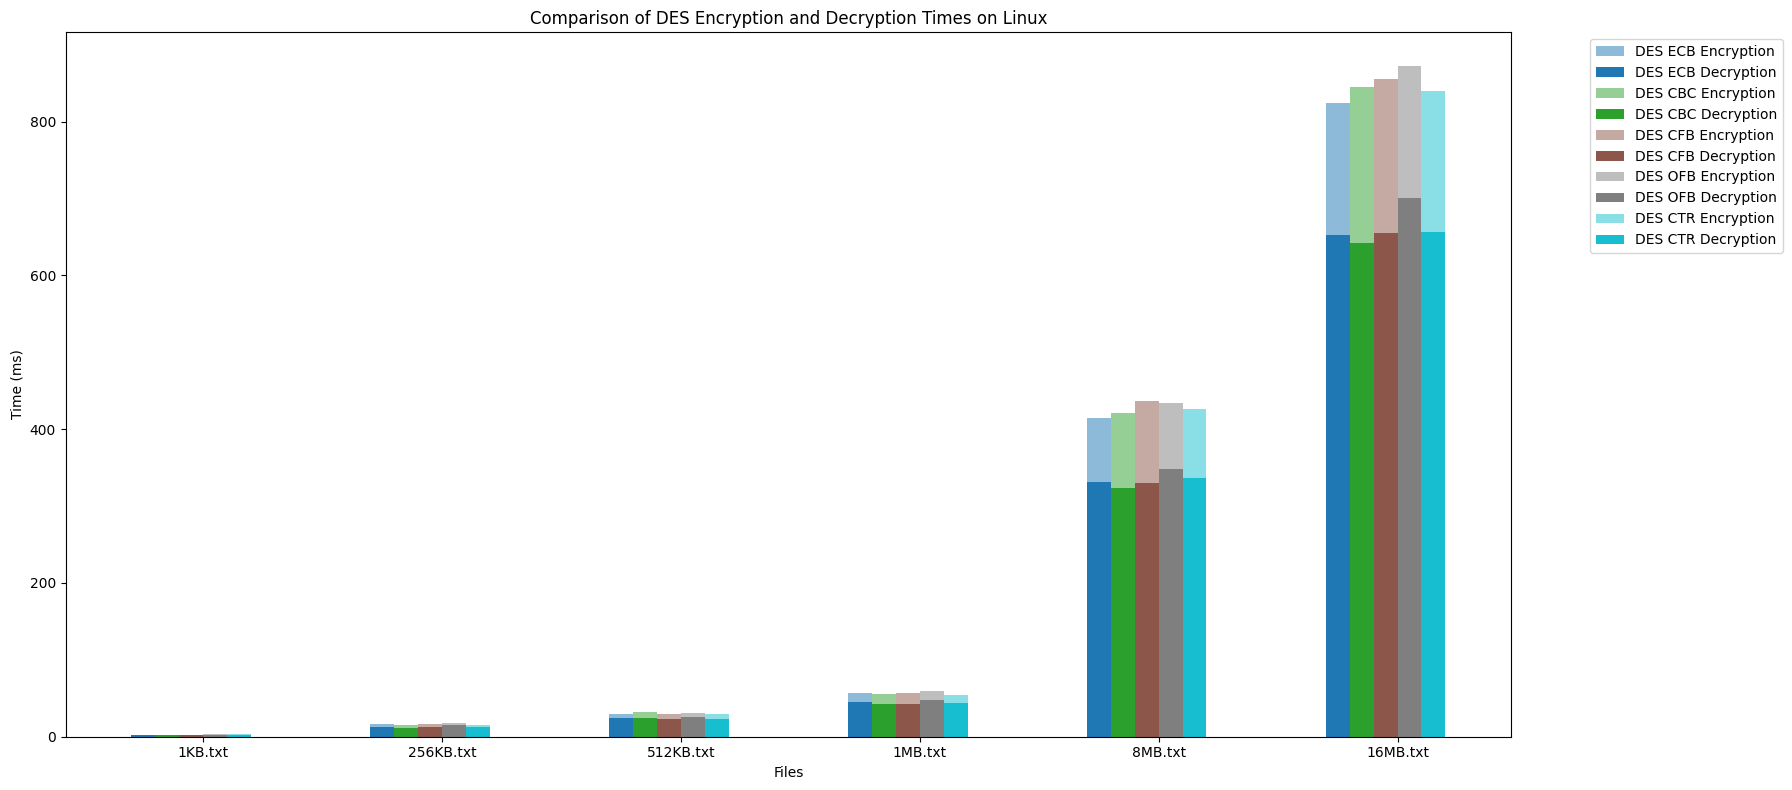

DES Results on macOS:
Algorithm Mode      File  encryption_mean  decryption_mean
      DES  ECB   1KB.txt            0.308            0.299
      DES  ECB 256KB.txt            6.838            5.492
      DES  ECB 512KB.txt           13.381           10.418
      DES  ECB   1MB.txt           25.723           20.527
      DES  ECB   8MB.txt          208.715          164.746
      DES  ECB  16MB.txt          414.391          326.309
      DES  CBC   1KB.txt            0.292            0.262
      DES  CBC 256KB.txt            7.581            5.360
      DES  CBC 512KB.txt           15.051           11.107
      DES  CBC   1MB.txt           29.117           20.681
      DES  CBC   8MB.txt          232.079          163.626
      DES  CBC  16MB.txt          462.694          326.994
      DES  CFB   1KB.txt            0.492            0.311
      DES  CFB 256KB.txt            7.418            5.611
      DES  CFB 512KB.txt           14.611           10.758
      DES  CFB   1MB.txt          

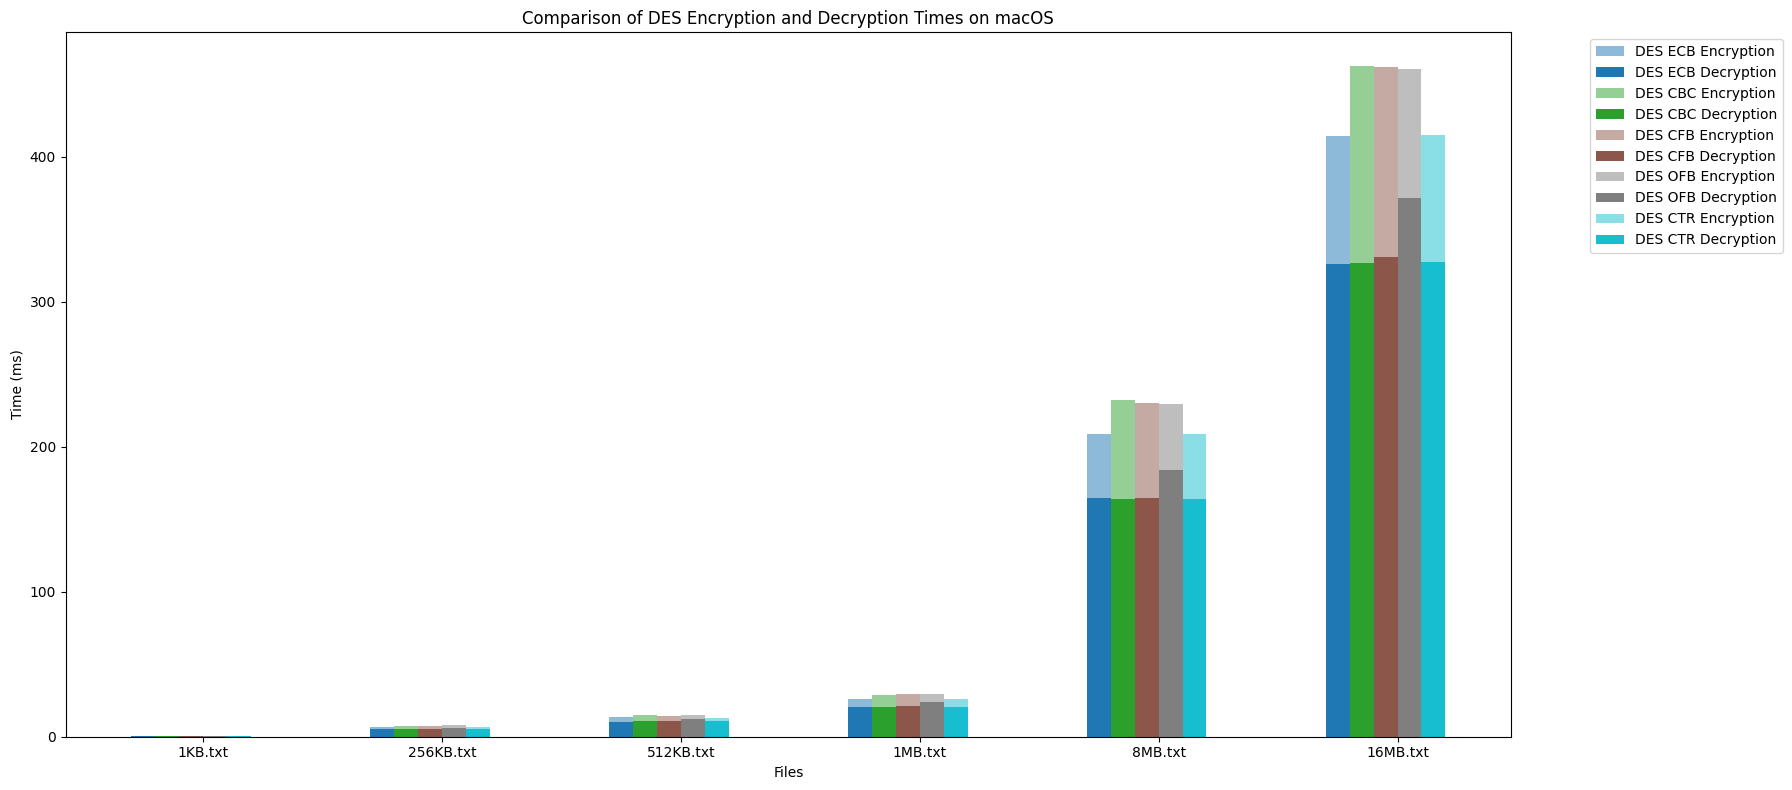

DES Results on Windows:
Algorithm Mode      File  encryption_mean  decryption_mean
      DES  ECB   1KB.txt            1.749            1.849
      DES  ECB 256KB.txt           16.176            9.545
      DES  ECB 512KB.txt           31.003           18.258
      DES  ECB   1MB.txt           58.132           33.564
      DES  ECB   8MB.txt          469.446          256.731
      DES  ECB  16MB.txt          906.108          497.112
      DES  CBC   1KB.txt            1.415            1.418
      DES  CBC 256KB.txt           16.303            9.254
      DES  CBC 512KB.txt           31.739           18.302
      DES  CBC   1MB.txt           63.048           35.143
      DES  CBC   8MB.txt          489.060          263.849
      DES  CBC  16MB.txt          916.883          502.390
      DES  CFB   1KB.txt            1.538            1.876
      DES  CFB 256KB.txt           15.319            8.965
      DES  CFB 512KB.txt           29.135           17.070
      DES  CFB   1MB.txt        

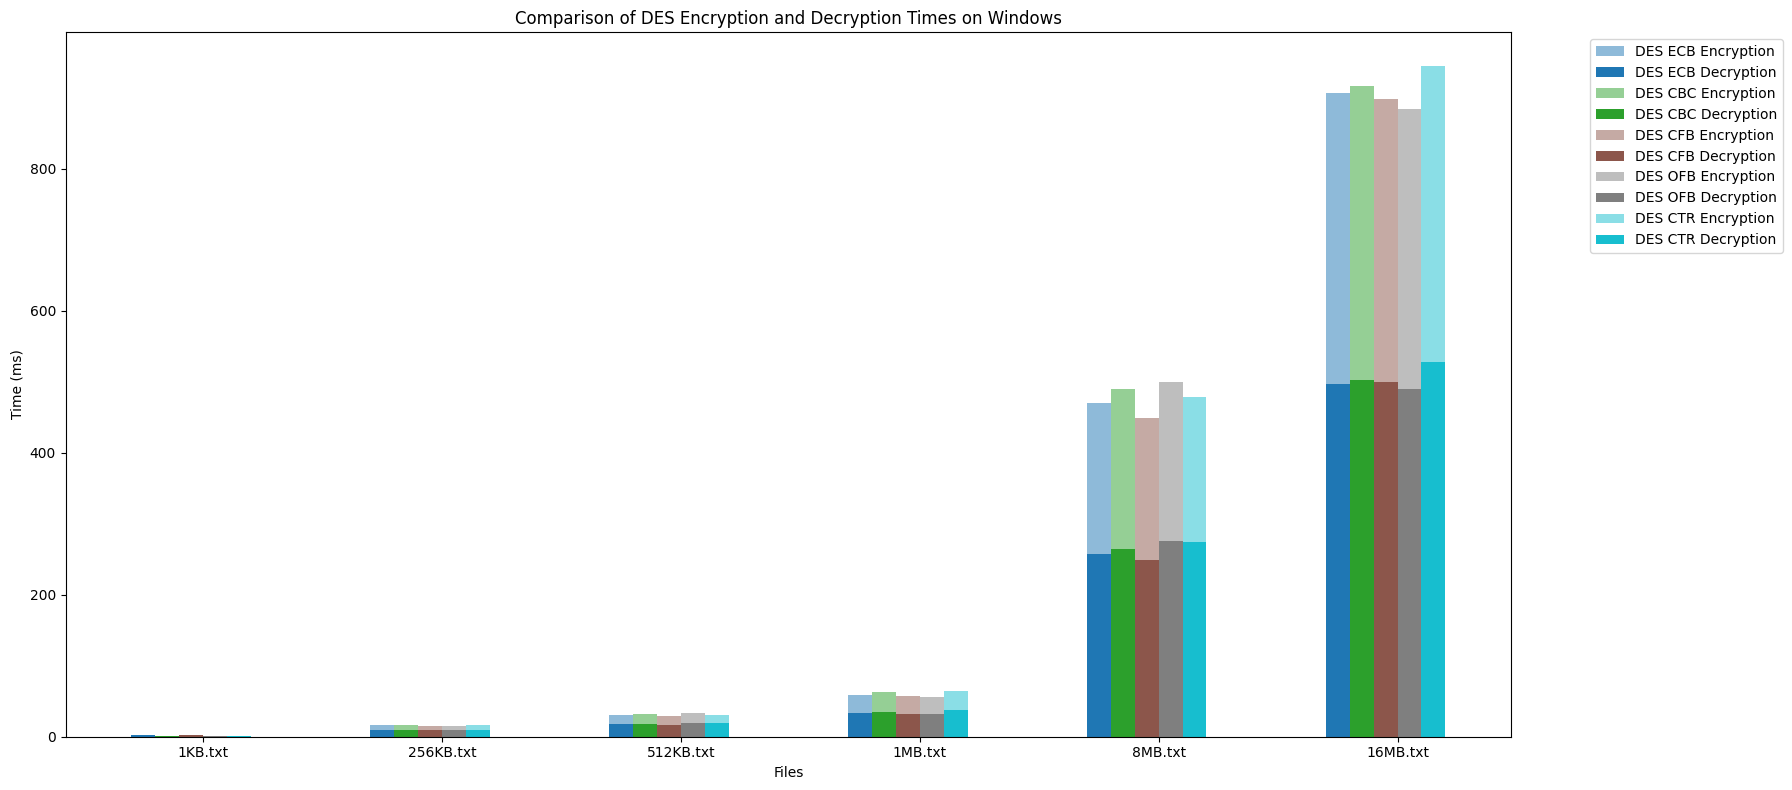

AES Results on Linux:
Algorithm Mode      File  encryption_mean  decryption_mean
      AES  ECB   1KB.txt            3.071            2.896
      AES  ECB 256KB.txt           13.437           11.033
      AES  ECB 512KB.txt           24.074           19.386
      AES  ECB   1MB.txt           45.403           35.977
      AES  ECB   8MB.txt          335.756          256.161
      AES  ECB  16MB.txt          680.132          512.986
      AES  CBC   1KB.txt            3.107            2.898
      AES  CBC 256KB.txt           13.376           10.514
      AES  CBC 512KB.txt           24.039           18.230
      AES  CBC   1MB.txt           46.225           35.172
      AES  CBC   8MB.txt          339.206          255.471
      AES  CBC  16MB.txt          687.068          514.746
      AES  CFB   1KB.txt            3.295            2.965
      AES  CFB 256KB.txt           14.031           10.980
      AES  CFB 512KB.txt           24.326           19.149
      AES  CFB   1MB.txt          

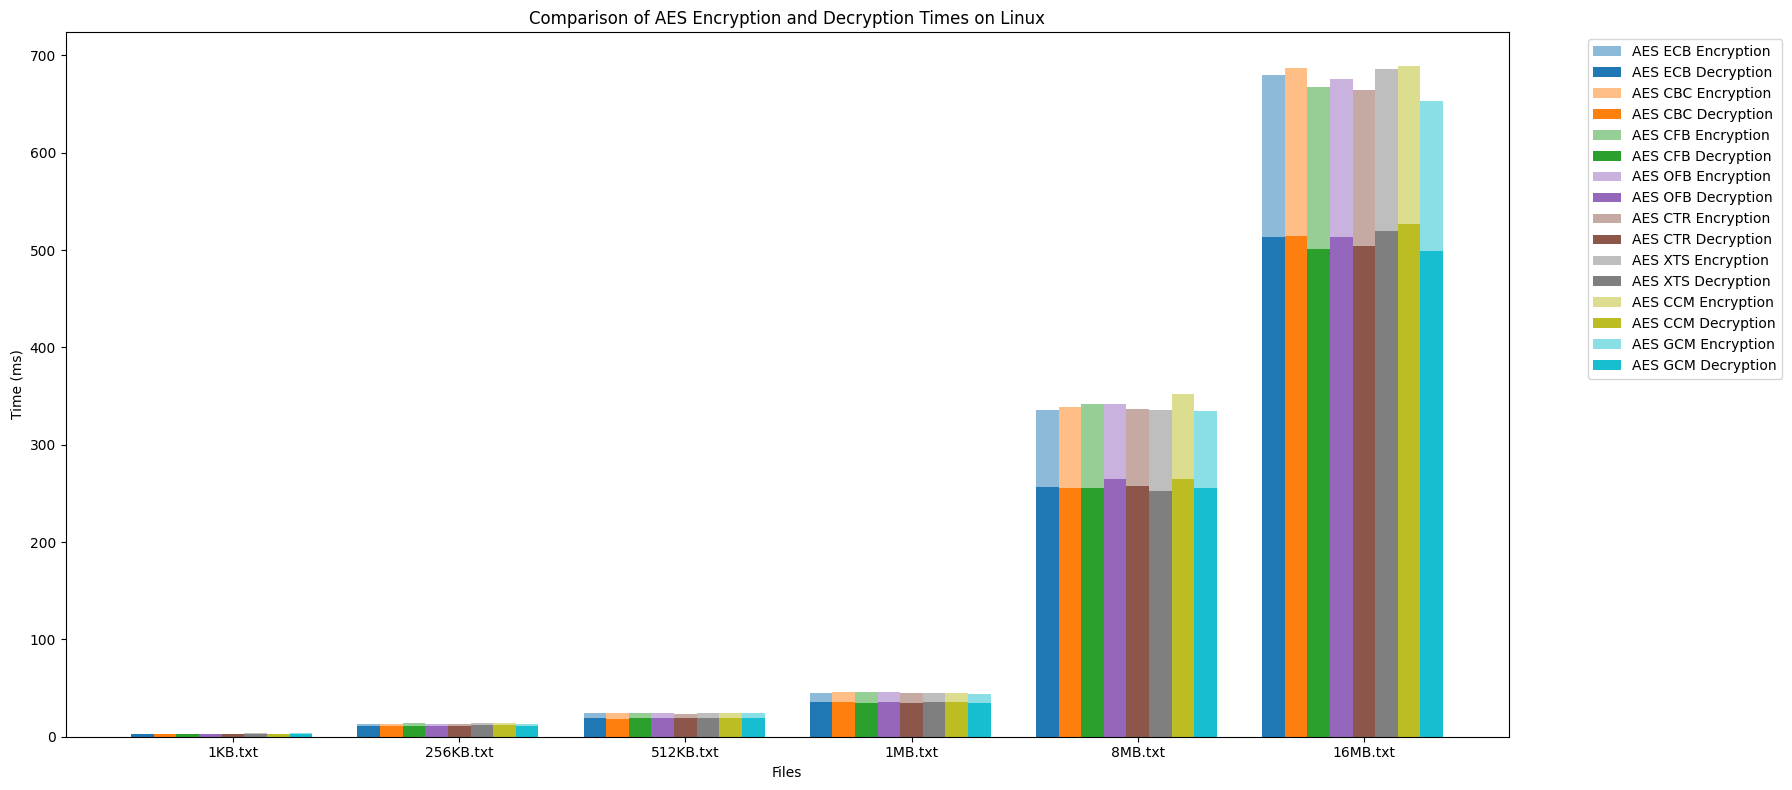

AES Results on macOS:
Algorithm Mode      File  encryption_mean  decryption_mean
      AES  ECB   1KB.txt            0.355            0.763
      AES  ECB 256KB.txt            3.955            2.442
      AES  ECB 512KB.txt            8.201            4.557
      AES  ECB   1MB.txt           15.229            9.261
      AES  ECB   8MB.txt          116.483           68.492
      AES  ECB  16MB.txt          230.736          137.700
      AES  CBC   1KB.txt            0.302            0.482
      AES  CBC 256KB.txt            4.808            2.462
      AES  CBC 512KB.txt            8.472            4.559
      AES  CBC   1MB.txt           15.535            9.097
      AES  CBC   8MB.txt          123.728           68.618
      AES  CBC  16MB.txt          249.950          138.897
      AES  CFB   1KB.txt            0.440            0.427
      AES  CFB 256KB.txt            4.374            2.648
      AES  CFB 512KB.txt            8.008            4.811
      AES  CFB   1MB.txt          

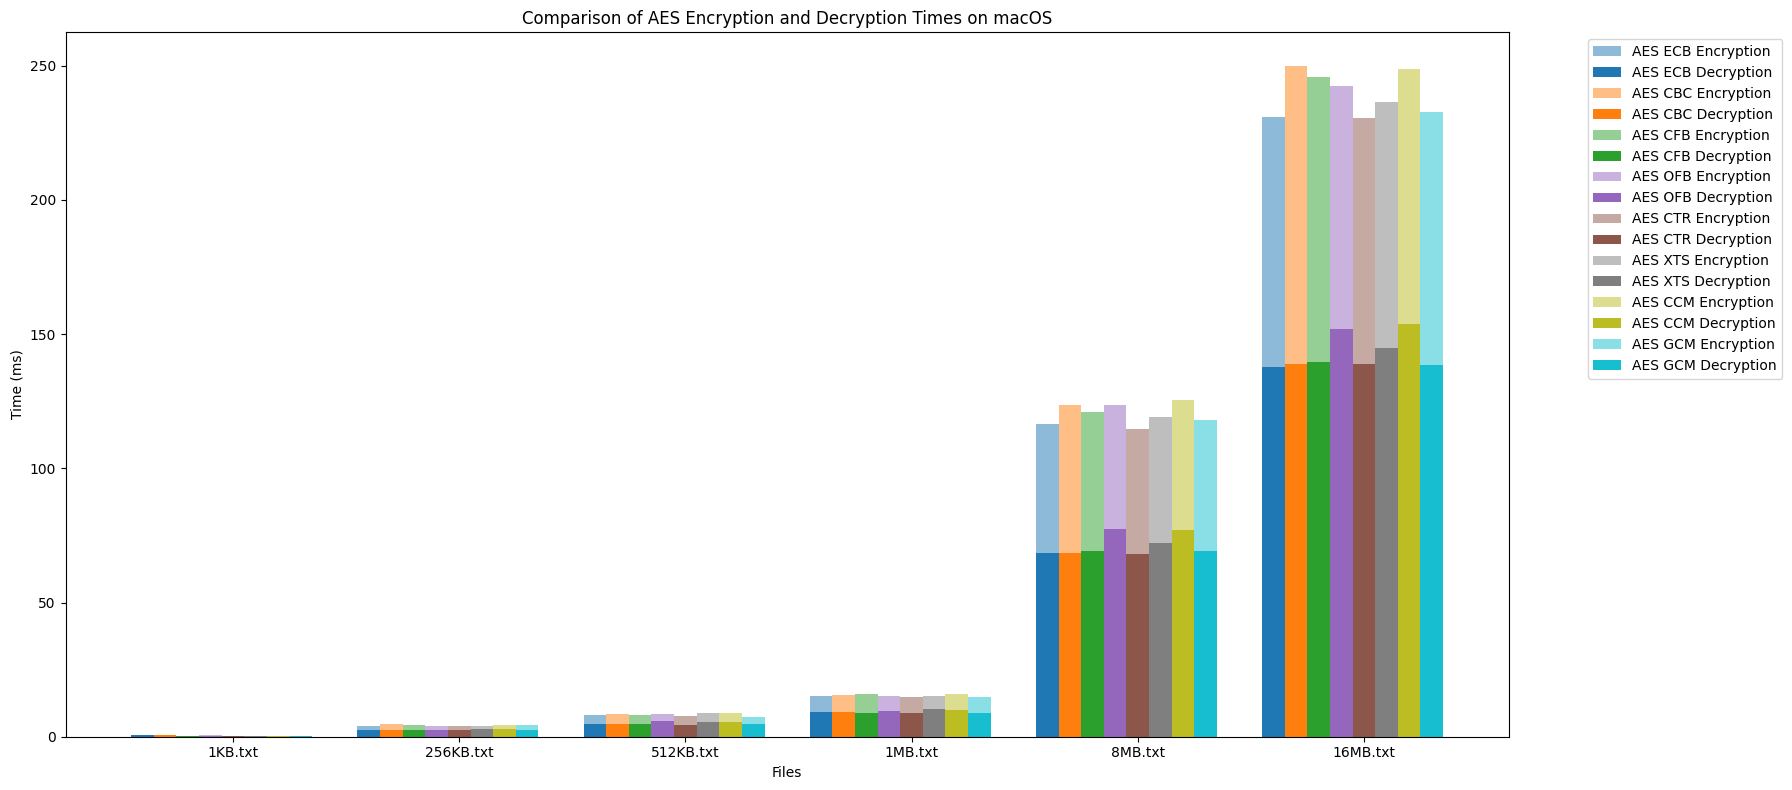

AES Results on Windows:
Algorithm Mode      File  encryption_mean  decryption_mean
      AES  ECB   1KB.txt            1.615            1.563
      AES  ECB 256KB.txt           13.626            6.559
      AES  ECB 512KB.txt           23.423           10.914
      AES  ECB   1MB.txt           50.485           20.670
      AES  ECB   8MB.txt          345.394          146.274
      AES  ECB  16MB.txt          710.134          295.836
      AES  CBC   1KB.txt            1.816            1.869
      AES  CBC 256KB.txt           12.897            6.160
      AES  CBC 512KB.txt           25.030           11.392
      AES  CBC   1MB.txt           47.684           20.976
      AES  CBC   8MB.txt          385.328          151.803
      AES  CBC  16MB.txt          743.532          291.423
      AES  CFB   1KB.txt            2.085            2.142
      AES  CFB 256KB.txt           13.158            6.078
      AES  CFB 512KB.txt           23.401           10.833
      AES  CFB   1MB.txt        

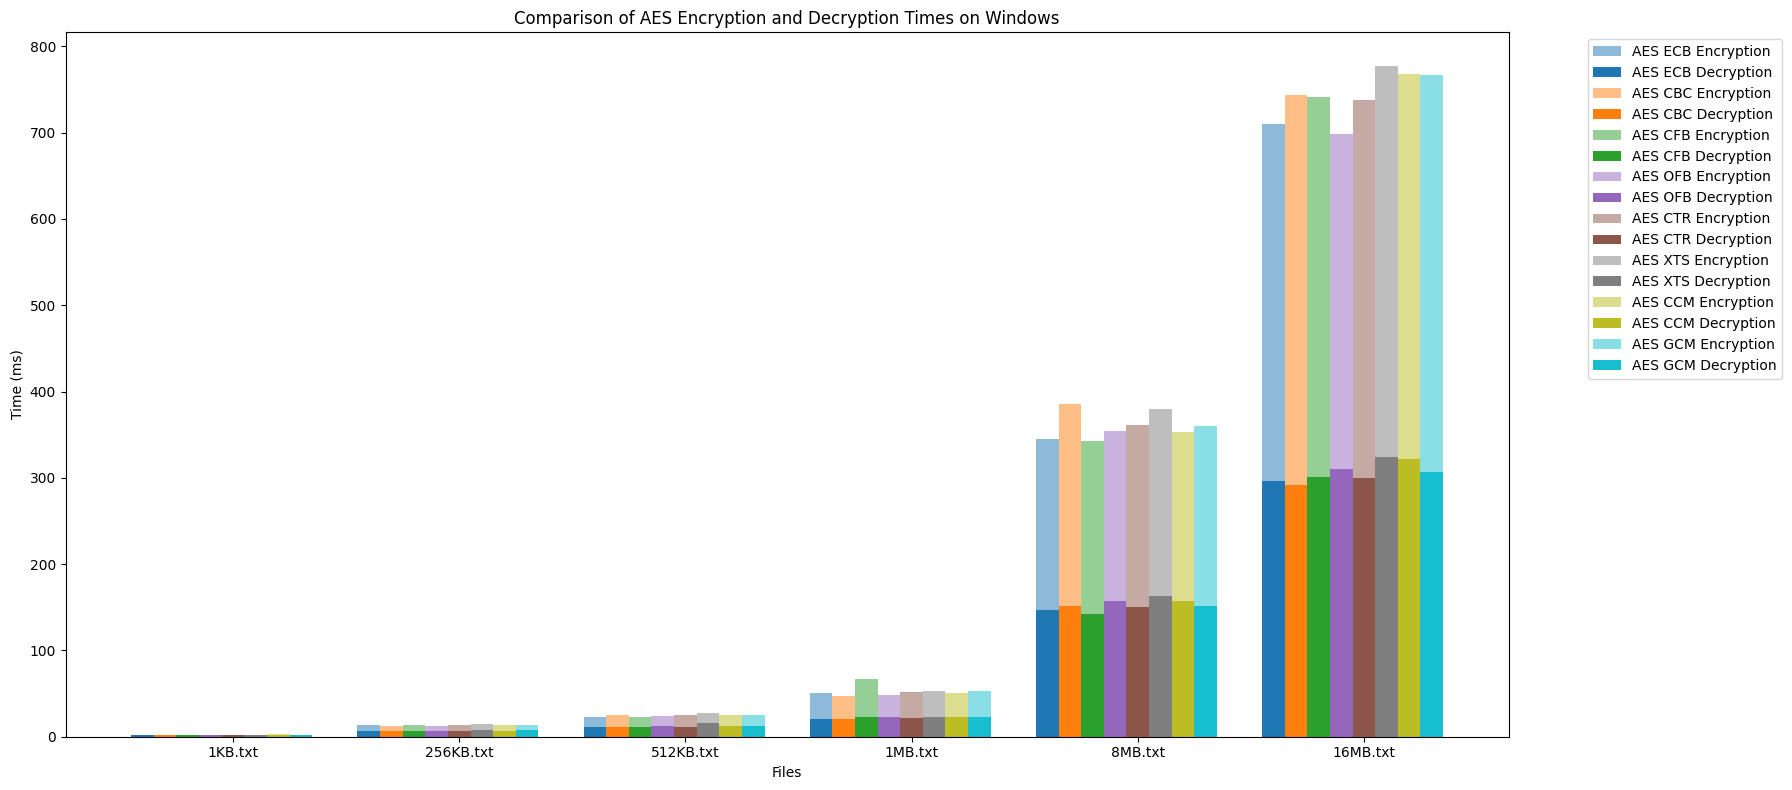

In [34]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# CSV files containing the results of the DES and AES tests
files = {
    'AES_Linux': './AES_Linux.csv',
    'AES_macOS': './AES_macOS.csv',
    'AES_Windows': './AES_Windows.csv',
    'DES_Linux': './DES_Linux.csv',
    'DES_macOS': './DES_macOS.csv',
    'DES_Windows': './DES_Windows.csv'
}

# List of modes for DES and AES
des_modes = ['ECB', 'CBC', 'CFB', 'OFB', 'CTR']
aes_modes = ['ECB', 'CBC', 'CFB', 'OFB', 'CTR', 'XTS', 'CCM', 'GCM']

# List of files used for the tests
input_files = ['1KB.txt', '256KB.txt', '512KB.txt', '1MB.txt', '8MB.txt', '16MB.txt']

# Initialize dictionaries to store the results
results_des = {'Linux': [], 'macOS': [], 'Windows': []}
results_aes = {'Linux': [], 'macOS': [], 'Windows': []}

# Read the results from the CSV files
for label, file_path in files.items():
    if os.path.exists(file_path) and os.path.getsize(file_path) > 0:
        # Read the CSV file into a DataFrame
        df = pd.read_csv(file_path)
        
        if not df.empty:
            # Calculate the mean encryption and decryption times for each mode and file
            os_name = label.split('_')[1]
            if 'DES' in label:
                for mode in des_modes:
                    mode_df = df[df['Mode'] == mode]
                    for file in input_files:
                        file_df = mode_df[mode_df['File'] == file]
                        encryption_mean = file_df['Encryption_Time'].mean()
                        decryption_mean = file_df['Decryption_Time'].mean()

                        # Save the results to the DES list
                        results_des[os_name].append({
                            'Algorithm': 'DES',
                            'Mode': mode,
                            'File': file,
                            'encryption_mean': encryption_mean,
                            'decryption_mean': decryption_mean
                        })
            elif 'AES' in label:
                for mode in aes_modes:
                    mode_df = df[df['Mode'] == mode]
                    for file in input_files:
                        file_df = mode_df[mode_df['File'] == file]
                        encryption_mean = file_df['Encryption_Time'].mean()
                        decryption_mean = file_df['Decryption_Time'].mean()

                        # Save the results to the AES list
                        results_aes[os_name].append({
                            'Algorithm': 'AES',
                            'Mode': mode,
                            'File': file,
                            'encryption_mean': encryption_mean,
                            'decryption_mean': decryption_mean
                        })

# Convert the results lists to DataFrames
results_df_des = {os: pd.DataFrame(data) for os, data in results_des.items()}
results_df_aes = {os: pd.DataFrame(data) for os, data in results_aes.items()}

# Function to create bar charts for a given algorithm's results
def plot_results(results_df, algorithm_name, modes):
    for os_name, df in results_df.items():
        if df.empty:
            print(f"No data available for {algorithm_name} on {os_name}.")
        else:
            # Show results
            print(f"{algorithm_name} Results on {os_name}:")
            print(df.to_string(index=False, float_format="{:.3f}".format))
            print()

            # Create a bar chart comparing encryption and decryption times
            fig, ax = plt.subplots(figsize=(18, 8))
            width = 0.1  # Width of the bars
            files_list = df['File'].unique()
            x_pos = np.arange(len(files_list))

            # Create a color for each mode
            colors = cm.tab10(np.linspace(0, 1, len(modes)))

            # Plot the bar chart for encryption_time and decryption_time
            for i, mode in enumerate(modes):
                mode_data = df[df['Mode'] == mode]
                for j, file_name in enumerate(files_list):
                    file_data = mode_data[mode_data['File'] == file_name]
                    encryption_mean = file_data['encryption_mean']
                    decryption_mean = file_data['decryption_mean']
                    bar_pos = x_pos[j] + i * width - width * (len(modes) / 2)
                    ax.bar(bar_pos, encryption_mean, width, label=f'{algorithm_name} {mode} Encryption' if j == 0 else "", color=colors[i], alpha=0.5)
                    ax.bar(bar_pos, decryption_mean, width, label=f'{algorithm_name} {mode} Decryption' if j == 0 else "", color=colors[i], alpha=1.0)

            # Add labels and title
            ax.set_xlabel('Files')
            ax.set_ylabel('Time (ms)')
            ax.set_title(f'Comparison of {algorithm_name} Encryption and Decryption Times on {os_name}')
            ax.set_xticks(x_pos)
            ax.set_xticklabels(files_list)
            ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

            # Show the plot
            plt.tight_layout()
            plt.show()

# Plot results for DES and AES
plot_results(results_df_des, 'DES', des_modes)
plot_results(results_df_aes, 'AES', aes_modes)


# Comparison based on OS

DES Results:
Algorithm      OS  encryption_mean  decryption_mean
      DES   Linux          229.917          179.850
      DES   macOS          119.116           90.488
      DES Windows          249.214          138.493



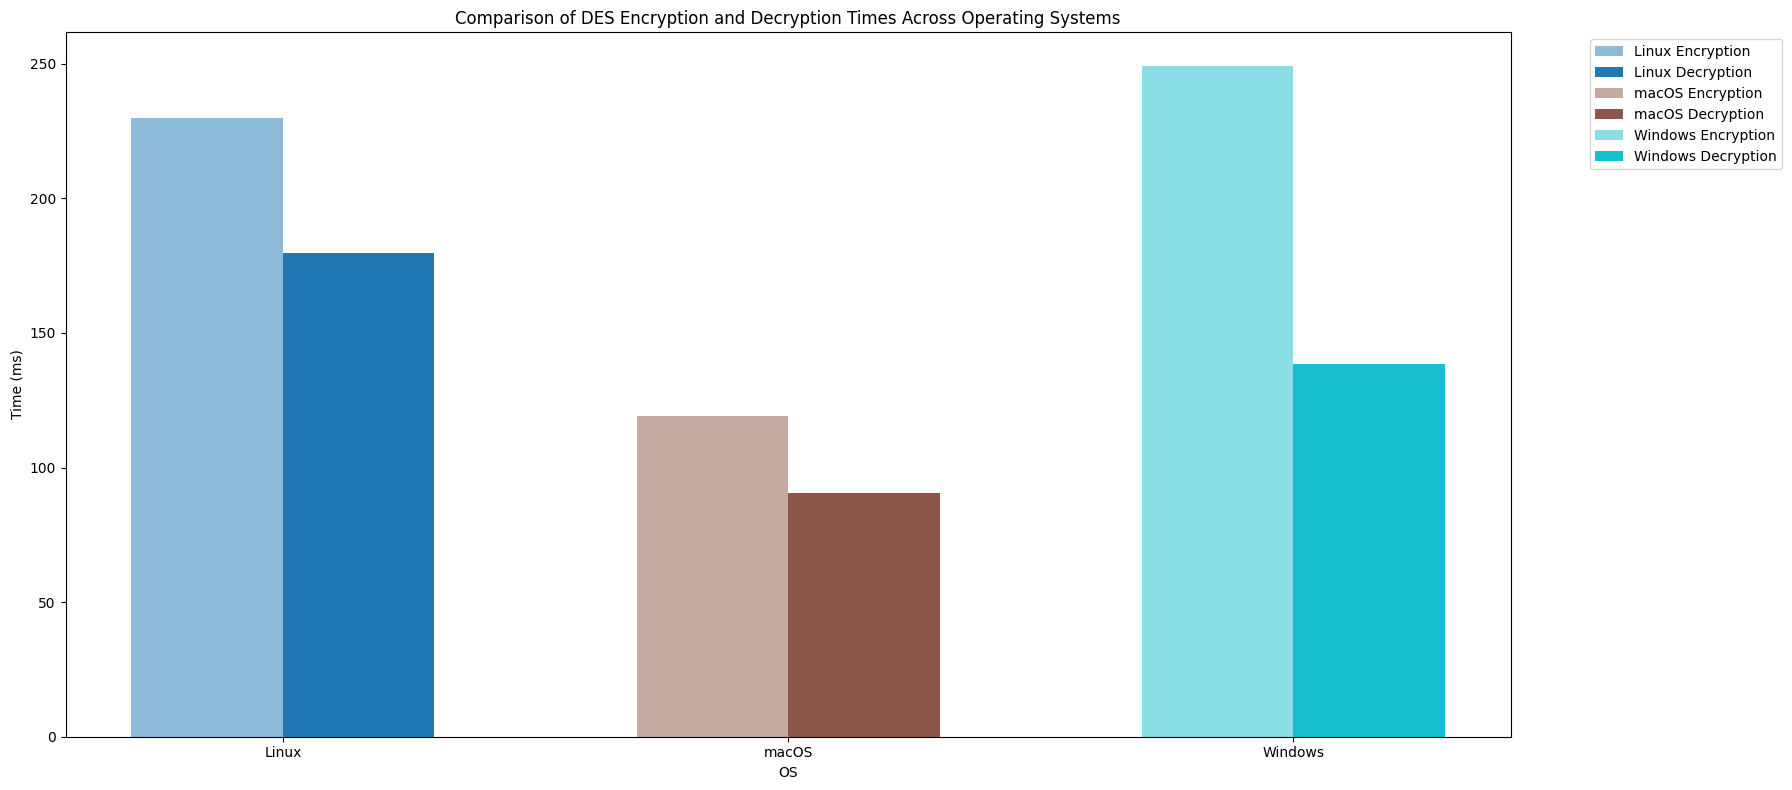

AES Results:
Algorithm      OS  encryption_mean  decryption_mean
      AES   Linux          183.473          139.596
      AES   macOS           64.751           38.543
      AES Windows          198.523           83.127



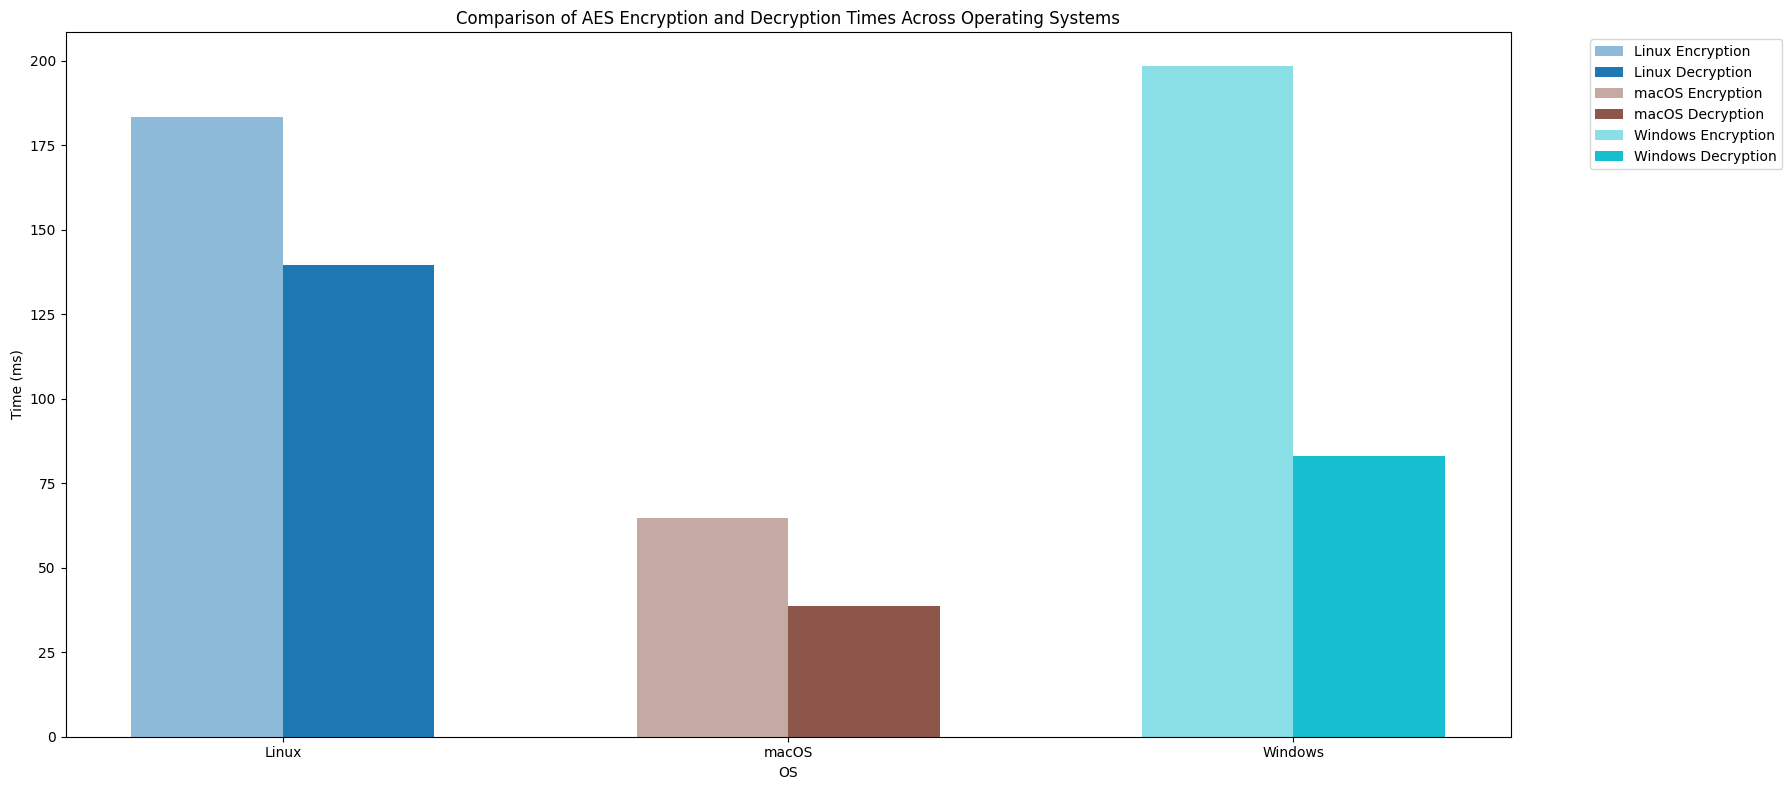

In [36]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm

# CSV files containing the results of the DES and AES tests
files = {
    'AES_Linux': './AES_Linux.csv',
    'AES_macOS': './AES_macOS.csv',
    'AES_Windows': './AES_Windows.csv',
    'DES_Linux': './DES_Linux.csv',
    'DES_macOS': './DES_macOS.csv',
    'DES_Windows': './DES_Windows.csv'
}

# Initialize lists to store the results
results = []

# Read the results from the CSV files
for label, file_path in files.items():
    if os.path.exists(file_path) and os.path.getsize(file_path) > 0:
        # Read the CSV file into a DataFrame
        df = pd.read_csv(file_path)
        
        if not df.empty:
            # Determine the algorithm and OS
            algorithm, os_name = label.split('_')
            
            # Add 'Algorithm' and 'OS' columns to the DataFrame
            df['Algorithm'] = algorithm
            df['OS'] = os_name

            # Calculate the mean encryption and decryption times for each file
            encryption_mean = df['Encryption_Time'].mean()
            decryption_mean = df['Decryption_Time'].mean()

            # Save the results to the list
            results.append({
                'Algorithm': algorithm,
                'OS': os_name,
                'encryption_mean': encryption_mean,
                'decryption_mean': decryption_mean
            })

# Convert the results list to a DataFrame
results_df = pd.DataFrame(results)

# Plot function
def plot_results(df, title, algorithm):
    if df.empty:
        print(f"No data available for {algorithm}.")
    else:
        # Show results
        print(f"{algorithm} Results:")
        print(df.to_string(index=False, float_format="{:.3f}".format))
        print()

        # Create a bar chart comparing encryption and decryption times
        fig, ax = plt.subplots(figsize=(18, 8))
        width = 0.3  # Width of the bars
        os_list = df['OS'].unique()
        x = np.arange(len(os_list))

        # Create a color for each OS
        colors = cm.tab10(np.linspace(0, 1, len(os_list)))

        # Plot the bar chart for encryption_time and decryption_time
        for i, os_name in enumerate(os_list):
            os_data = df[df['OS'] == os_name]
            encryption_mean = os_data['encryption_mean']
            decryption_mean = os_data['decryption_mean']
            
            ax.bar(x[i] - width/2, encryption_mean, width, label=f'{os_name} Encryption', color=colors[i], alpha=0.5)
            ax.bar(x[i] + width/2, decryption_mean, width, label=f'{os_name} Decryption', color=colors[i], alpha=1)

        # Add labels and title
        ax.set_xlabel('OS')
        ax.set_ylabel('Time (ms)')
        ax.set_title(title)
        ax.set_xticks(x)
        ax.set_xticklabels(os_list)
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

        # Show the plot
        plt.tight_layout()
        plt.show()

# Plot DES results
plot_results(results_df[results_df['Algorithm'] == 'DES'], 'Comparison of DES Encryption and Decryption Times Across Operating Systems', 'DES')

# Plot AES results
plot_results(results_df[results_df['Algorithm'] == 'AES'], 'Comparison of AES Encryption and Decryption Times Across Operating Systems', 'AES')
